In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg
import scipy.stats
from scipy.ndimage.filters import gaussian_filter1d
from six.moves import urllib
import os
import sklearn.decomposition
import warnings
warnings.simplefilter('ignore')

# create dataset and discrete classification
# y = x + gaussian random noise
# => latent variable is identity line
N = 100
x = np.random.random((N,))
y = x + .2*np.random.randn(N)

x = np.vstack((x,y))
cm = np.array([[1,0,0],[0,0,1]])
cms = np.zeros((N,3))
cms[x[0,:]>.5,:] = cm[0,:]
cms[x[0,:]<=.5,:] = cm[1,:]

# download 2-photon data (if not already downloaded)
if not os.path.isfile('data/mesoscope_activity.npy'):
    if not os.path.exists('data'):
        os.mkdir('data')
    response = urllib.request.urlopen('http://www.gatsby.ucl.ac.uk/~cstringer/mesoscope_activity.npy');
    f=open('data/mesoscope_activity.npy','wb')
    f.write(response.read())
    f.close()
    
# load downloaded data
dat = np.load('data/mesoscope_activity.npy')
dat = dat.item()
sp  = dat['spks']
xyloc = dat['xyloc']

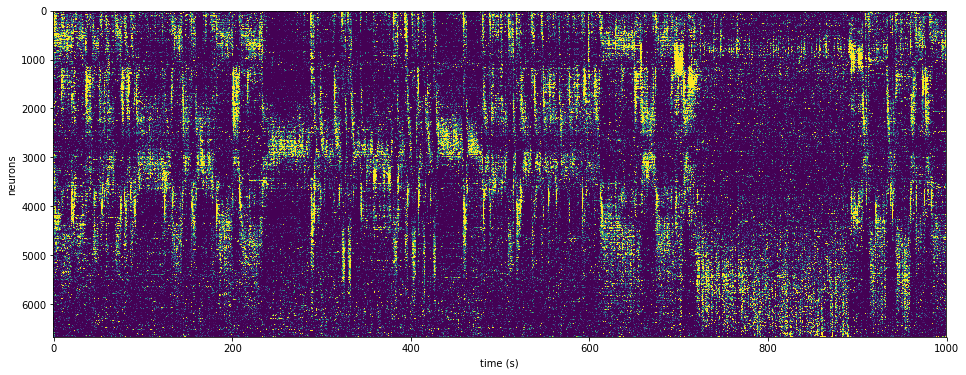

In [3]:
import rastermap # (pip install rastermap)
# run rastermap on neural data example
ops = {'nclust': 20, # number of clusters
       'iPC': np.arange(0,200).astype(np.int32), # number of PCs to use
       'upsamp': 100, # upsampling factor for embedding position
        'sigUp': 1, # standard deviation for upsampling
        'dims': 1,
       'equal': False
    }
isort1,isort2 = rastermap.mapping.main(sp-sp.mean(axis=1)[:,np.newaxis], ops)
isort1 = isort1[::-1]

def plot_sorting(sp, isort1, tpts, ax):
    ax.imshow(gaussian_filter1d(sp[isort1,:tpts],5,axis=0),aspect='auto',vmin=0.2,vmax=.6)
    ax.set_xlabel('time (s)')
    ax.set_ylabel('neurons')

fig=plt.figure(figsize=(16,6)); ax = fig.add_subplot(111)
plot_sorting(sp, isort1, 1000, ax)

In [4]:
# plot 2D data
def plot_example_clusters():
    fig = plt.figure(figsize=(12,4)); ax1 = fig.add_subplot(1,3,1); 
    ax2 = fig.add_subplot(1,3,2); ax3 = fig.add_subplot(1,3,3)
    # original data
    ax1.scatter(x[0,:],x[1,:],color=(.5,.5,.5),s=8)
    ax1.set_title('example data')
    # data with discrete classification
    ax2.scatter(x[0,:],x[1,:],color=cms,s=8)
    ax2.set_title('data split into two clusters')
    # continuous latent variable representation
    ax3.scatter(x[0,:],x[1,:],color=(.5,.5,.5),s=8)
    ax3.plot(x[0,:],x[0,:],color='k')
    ax3.set_title('axis of maximum variance')
    plt.show();

# plot SVD projections in 2D data
def plot_projections(xsub, uall, which_pc):
    for w in which_pc:
        u = uall[:,(w-2)]
        ax1.scatter(xsub[0,:],xsub[1,:],color=(.5,.5,.5),s=8) # original points
        # projection
        ax1.plot(xsub[0,:]*u[0] , xsub[0,:] * u[1],color='k')
        
        # low-dimensional representation
        ax2.scatter(xsub[0,:],xsub[1,:],color=(.5,.5,.5),s=8)
        ax2.scatter(xsub.T @ u *u[0], xsub.T @ u *u[1], color=(1,.5,.5), s=10)
    if len(which_pc)>1:
        ax1.set_title('principal component %d,%d'%(which_pc[0], which_pc[1]))
        ax2.set_title('projection of x onto PC %d,%d'%(which_pc[0],which_pc[1]))
    else:
        ax1.set_title('principal component %d'%(which_pc[0]))
        ax2.set_title('projection of x onto PC %d'%which_pc[0])
    ax1.set_xlim([-1,1])
    ax1.set_ylim([-1,1])
    ax2.set_xlim([-1,1])
    ax2.set_ylim([-1,1]) 
    ax1.set_autoscale_on
    ax2.set_autoscale_on
    plt.show()


In [5]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# plot low-D representation of neurons
def neural_lowd(d):
    fig = plt.figure(figsize=(16,6)); ax1 = fig.add_subplot(111);
    if d<=100:
        sp_lowd = u[:,-d:] @ (u[:,-d:].T @ sp_sub)
    else:
        sp_lowd = sp_sub
    sp_lowd = sp_lowd + sp.mean(axis=1)[:,np.newaxis]
    plot_sorting(sp_lowd, isort1, 1000, ax1)    
    if d<=100:
        ax1.set_title(('%d-dimensional'%d))
    else:
        ax1.set_title('full-dimensional')
    plt.show()
    return


In [6]:
def plot_nmf_vs_pca(sp,W,H,u,dNMF,dPCA):
    fig = plt.figure(figsize=(24,4)); ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122);
    plot_sorting(W@H, isort1, 1000, ax1) # NMF
    ax1.set_title('NMF %d-dimensional'%dNMF)
    sp_mean = sp.mean(axis=1)[:,np.newaxis]
    sp_lowd = u[:,-dPCA:] @ (u[:,-dPCA:].T @ (sp-sp_mean)) + sp_mean
    plot_sorting(sp_lowd, isort1, 1000, ax2) # PCA
    ax2.set_title('PCA %d-dimensional'%dPCA)

In [7]:
def ica_example(sp, neurons):
    fig = plt.figure(figsize=(18,10)); 
    ax1 = fig.add_subplot(141)
    ax2 = fig.add_subplot(142)
    ax3 = fig.add_subplot(143)
    ax4 = fig.add_subplot(144)

    for k,neuron in enumerate(neurons):
        x1 = sp[neuron,:]
        if k>0:
            x = np.vstack((x,x1))
        else:
            x = x1
    x = x.T
    n = x.shape[1]
    for k in range(n):
        ax1.plot(x[:,k]+x.max()*(n-k))
    ax1.set_title('original neurons')
    #ax1.axis('tight')
    ax1.axis('off')
    #ax1.set_ylim((0,25))

    M = np.random.random((n,n))
    
    #M = np.array([[1, 1], [0.5, 0.25]]) # mixing matrix
    mixedX = x @ M
    for k in range(n):
        ax2.plot(mixedX[:,k]+mixedX.max()*(n-k))
    ax2.set_title('mixed neurons')
    ax2.axis('tight')
    ax2.axis('off')
    
    model = sklearn.decomposition.FastICA(n_components=n, whiten=True)
    out = model.fit_transform(mixedX)
    # find which components are correlated to which neuron
    cc = np.corrcoef(x.T,out.T)
    cc = cc[np.ix_(np.arange(0,n).astype(int),np.arange(n,2*n).astype(int))]
    ccabs = np.absolute(cc)
    order = np.argmax(ccabs,axis=1)
    sign = np.sign(cc[np.arange(0,n).astype(int),order.astype(int)])
    for k in range(n):
        p=ax3.plot(out[:,order[k]] * sign[k]+np.absolute(out).max()*(n-k))
        ax3.text(0,(n-k+.65)*np.absolute(out).max(),
                 'correlation = %1.3f'%ccabs[k,order[k]], color=p[0].get_color())
    #ax3.axis('tight')
    ax3.axis('off')
    ax3.set_title('ICA demixing')

    mixedXsub = mixedX-mixedX.mean(axis=0)[np.newaxis]
    covX = mixedXsub.T @ mixedXsub
    sv,u = scipy.linalg.eigh(covX)
    xproj = mixedXsub @ u
    xproj = xproj * np.sign(scipy.stats.skew(xproj))[np.newaxis,:]
    xproj = xproj[:,::-1]
    for k in range(n):
        ax4.plot(xproj[:,k]+xproj.max()/2*(n-k))
    ax4.axis('tight')
    ax4.axis('off')
    ax4.set_title('principal components')
    plt.show()

# Unsupervised learning II 
## Continuous latent variables

Carsen Stringer

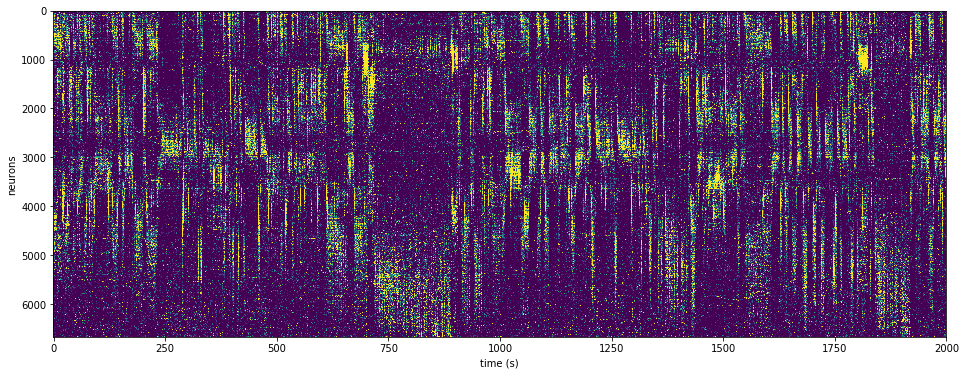

In [8]:
fig=plt.figure(figsize=(16,6)); ax = fig.add_subplot(111)
plot_sorting(sp, isort1, 2000, ax)

## Outline
- principal component analysis
    - derivation and low-dimensional reconstructions
    - PCA = SVD

- non-negative matrix factorization

- independent component analysis

- nonlinear methods
    - t-SNE
    - UMAP

## Previous lecture

Latent variables assumed to be **discrete**, e.g. cluster-identity

However, we can try to represent high-dimensional data using **continuous** low-dimensional latent variables





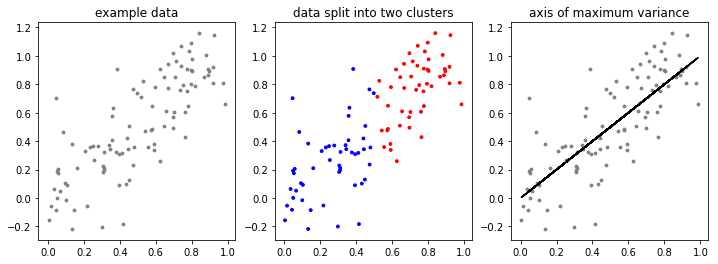

In [9]:
plot_example_clusters()

## Principal component analysis

Find a low-dimensional representation that maximizes variance
(this is equivalent to minimizing the reconstruction error (see [Bishop](http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf) for proof))

Let $\mathbf{u}$ be a unit vector: $\mathbf{u}^\top \mathbf{u} = 1$

The projection of $\mathbf{x}_n$ into the latent space $\mathbf{u}$ is $\mathbf{u}^\top \mathbf{x}$

The mean of $\mathbf{x}_n$ is $\overline{\mathbf{x}} = \frac{1}{N} \sum\limits_{n=1}^N \mathbf{x}_n$

Then the mean of the projection is $\mathbf{u}^T \overline{\mathbf{x}}$. 

## Principal component analysis

Find a projection $\mathbf{u}$ that maximizes variance
\begin{align*}
\text{variance} &= \frac{1}{N} \sum_n (\mathbf{u}^\top \mathbf{x}_n - \mathbf{u}^\top \overline{\mathbf{x}})^2 \\
&= \frac{1}{N} \sum_n (\mathbf{u}^\top (\mathbf{x}_n - \overline{\mathbf{x}}))^2 \\
&= \frac{1}{N} \sum_n (\mathbf{u}^\top (\mathbf{x}_n - \overline{\mathbf{x}}))(\mathbf{u}^\top (\mathbf{x}_n - \overline{\mathbf{x}}))^\top \\
&=  \mathbf{u}^\top \left[ \frac{1}{N} \sum_n (\mathbf{x}_n - \overline{\mathbf{x}}) (\mathbf{x}_n - \overline{\mathbf{x}})^\top \right] \mathbf{u} \\
&= \mathbf{u}^\top C \mathbf{u}
\end{align*}

where $C$ is the data covariance matrix

## Principal component analysis

Find a projection $\mathbf{u}$ that maximizes variance

$\max\limits_{\mathbf{u}} \text{variance} = \max\limits_{\mathbf{u}} \mathbf{u}^\top C \mathbf{u} \qquad$ (with constraint $\mathbf{u}^\top \mathbf{u} = 1)$

We can perform constrained optimization using *Lagrange multipliers*: Define a new function $g$
\begin{align*}
g(\mathbf{u}, \lambda) &= \mathbf{u}^\top C \mathbf{u} + \lambda (1 - \mathbf{u}^\top \mathbf{u}) \\
\frac{\partial g}{\partial \lambda} &= 1 - \mathbf{u}^\top \mathbf{u} = 0 \Rightarrow \mathbf{u}^\top \mathbf{u} = 1\\
\frac{\partial g}{\partial \mathbf{u}} &= 2 C \mathbf{u} - 2 \lambda \mathbf{u} = 0\\
\Rightarrow C\mathbf{u} &= \lambda \mathbf{u}
\end{align*}

The minimum of $g$ satisfies the constraint AND minimizes the original function - why? At the optimum,

$g(\mathbf{u}, \lambda) = \mathbf{u}^\top C \mathbf{u} + \lambda (1 - \mathbf{u}^\top \mathbf{u}) = \mathbf{u}^\top C \mathbf{u}$ (because constraint is satisfied)

## Principal component analysis

$C\mathbf{u} = \lambda \mathbf{u}$ where $C$ is the data covariance

$\Rightarrow \mathbf{u}$ is an eigenvector.

And it's the eigenvector the **largest** eigenvalue:

\begin{align*}
\mathbf{u}^\top C \mathbf{u} &= \lambda \mathbf{u}^\top \mathbf{u}\\
\mathbf{u}^\top C \mathbf{u} &= \lambda 
\end{align*}


## Principal component analysis

What's the next dimension? Subtract off projection onto $\mathbf{u}$: 

$\hat{C} = C - C \mathbf{u} \mathbf{u}^\top $

Then find top eigenvector $\mathbf{\hat{u}}$. This eigenvector is also an eigenvector of $C$:

$C \mathbf{\hat{u}} = (\hat{C} + C\mathbf{u} \mathbf{u}^\top)\mathbf{\hat{u}} = \hat{C} \mathbf{\hat{u}} + 0 = \lambda \mathbf{\hat{u}} $

So all the principal components are eigenvectors of the covariance matrix $C$.

Note that the PCA computational cost scales as order $D^3$ where $D$ is the dimensionality of the matrix. If you only need the top $k$ dimensions, you can reduce this to $kD^2$ cost. See the function for example:

    U = scipy.sparse.linalg.eigsh(C, k=100)
    
This is a fast implementation too (just be aware the eigenvectors come in the opposite order - smallest first!)

## Principal component analysis

**What is the reconstruction of a point from the low-D space?**

Let $\mathbf{u}_i$ be the principal components. Then
$\mathbf{x} = \sum\limits_{i=1}^D \alpha_i \mathbf{u}_i$. What is $\alpha_i$?

\begin{align*}
\mathbf{x}^\top \mathbf{u}_j &= (\sum\limits_{i=1}^D \alpha_i \mathbf{u}_i^\top) \mathbf{u}_j\\
&= \sum\limits_{i=1}^D \alpha_i (\mathbf{u}_i^\top \mathbf{u}_j) \\
&= \alpha_j \mathbf{u}_j^\top \mathbf{u}_j \\
&= \alpha_j
\end{align*}

So then $\alpha_j = \mathbf{x}^\top \mathbf{u}_j $ and therefore $\mathbf{x} = \sum\limits_{i=1}^D (\mathbf{x}^\top \mathbf{u}_i) \mathbf{u}_i $

## Principal component analysis

### What is the reconstruction of a point  the low-D space?

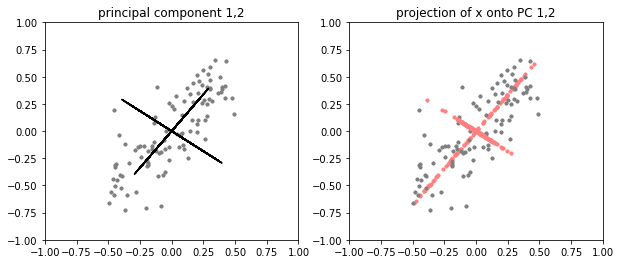

In [11]:
## find first PC
xmean = x.mean(axis=1)[:,np.newaxis]
xsub = x - xmean
sv,u = scipy.sparse.linalg.eigsh(xsub @ xsub.T, k=2)

which_pc = [1, 2]
fig = plt.figure(figsize=(10,4)); ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122);
plot_projections(xsub, u, which_pc)

## Principal component analysis (neural example)

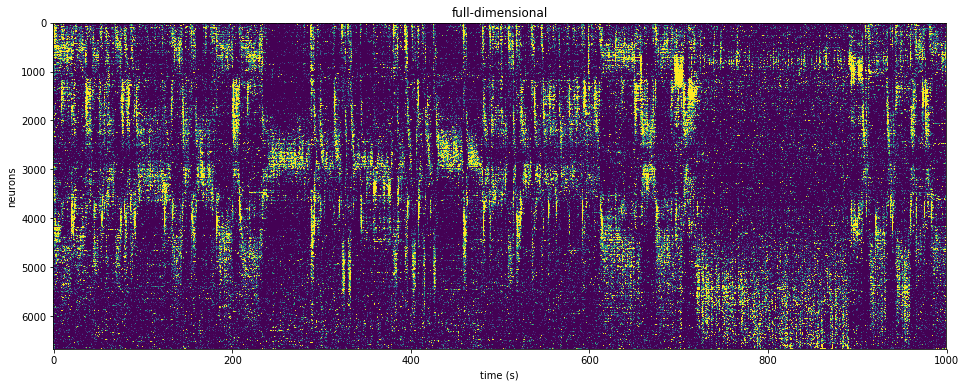

In [12]:
# sp is neurons x timepts, find first PC
# mean center data
sp_sub  = sp - sp.mean(axis=1)[:,np.newaxis]
sv,u  = scipy.sparse.linalg.eigsh(sp_sub @ sp_sub.T,k=100)
# low-dimensional approximation:
sp_lowd = u @ (u.T @ sp_sub)

interact(neural_lowd, d=widgets.IntSlider(min=1,max=101,step=1,value=101,continuous_update=False));

## Principal component analysis  =  Singular value decomposition

Singular value decomposition decomposes any matrix M into two orthonormal matrices (U,V) and a diagonal matrix $\Sigma$ (image from wikipedia)

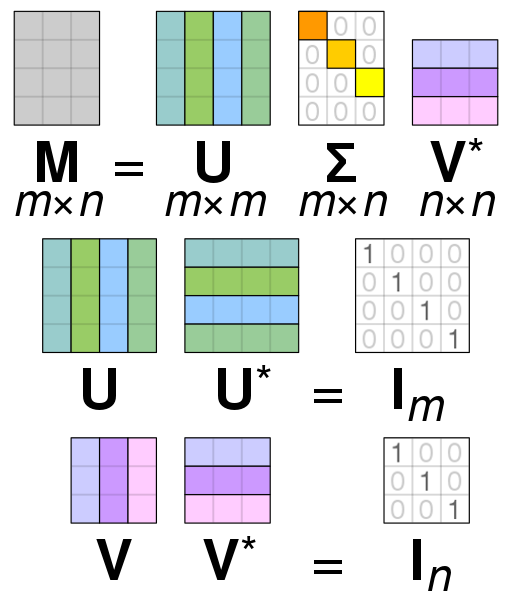

## Principal component analysis  =  Singular value decomposition

Let's assume M is mean-centered (mean of each row of M is 0). Then if

$M = U\Sigma V^\top$

Then this _U_ is the same as the one from PCA (which decomposes the covariance):

$MM^\top = USU^\top$

Proof (plug in M's svd into the covariance):
\begin{align*}
MM^\top &= (U\Sigma V^\top)(U\Sigma V^\top)^\top \\
 &= U\Sigma V^\top V \Sigma^\top U^\top  \qquad \qquad (V^\top V = I) \\
 &= U \Sigma \Sigma^\top U^\top \qquad \qquad \qquad (\Sigma^\top = \Sigma)\\
 &= U \Sigma^2 U^\top
\end{align*}

So the principal components are the same as the singular vectors!

## Principal component analysis 

### Pros
* linear model
* fast (can choose how many PCs to extract, can use covariance to reduce size)

### Cons
* linear model
* forces orthogonal dimensions
* extracts both positive and negative weights

**non-negative matrix factorization** puts a constraint on components (requires all positive weights)

$X = WH \qquad \text{where } W\ge 0, H\ge 0$ 

## Non-negative matrix factorization (NMF)

(sklearn.decomposition.nmf) $\qquad X = WH \qquad \text{where } W\ge 0, H\ge 0$ 

Can optimize cost function $J$ by gradient descent (after each step manually rectify $W$ and $H$):
\begin{align*}
\min_{W,H} J(W,H) &= \min \| X - WH \|^2 \\
&= \min X^\top X - 2 X^\top W H + H^\top W^\top W H
\end{align*}

$\frac{\partial J}{\partial H} = -2 X^\top W + 2 W^\top W H \qquad \frac{\partial J}{\partial W} = -2 XH^\top + 2 WHH^\top$

$H_{(t+1)} = H_{(t)} + \eta \frac{\partial J}{\partial H} \qquad \qquad W_{(t+1)} = W_{(t)} + \eta \frac{\partial J}{\partial W}$

## Non-negative matrix factorization (NMF)

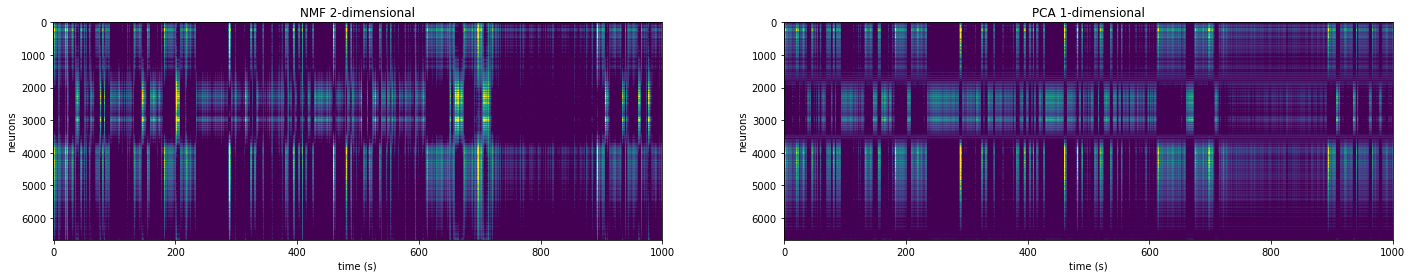

In [14]:
# sp ~ W @ H
# sp is neurons x timepts, find first PC
dNMF  = 2 # dimensionality of NMF
model = sklearn.decomposition.NMF(n_components=dNMF, init='nndsvda')
W     = model.fit_transform(sp)
H     = model.components_

plot_nmf_vs_pca(sp,W,H,u,dNMF,dPCA=1)

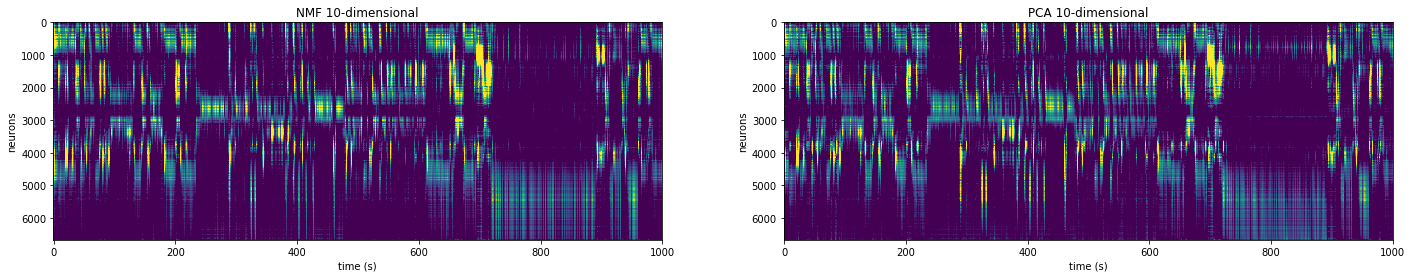

In [15]:
# sp ~ W @ H
# sp is neurons x timepts, find first PC
dNMF  = 10 # dimensionality of NMF
model = sklearn.decomposition.NMF(n_components=dNMF, init='nndsvda')
W     = model.fit_transform(sp)
H     = model.components_

plot_nmf_vs_pca(sp,W,H,u,dNMF,dPCA=10)

## Non-negative matrix factorization (NMF)

Positivity may not always be the right, or a sufficient criterion for decomposition.

Other criteria:
* sparsity (L0/L1)
* skewness
* temporal smoothness

To find sparse components:
* independent component analysis (ICA)
* sparse coding
* dictionary learning
* Boltzmann machines


## Independent component analysis (ICA)

- assumes independent random variables are mixed
- tries to find demixing matrix W 
- **Model**: x = W<sup>-1</sup>s where s are the independent signals
- IDEA: sum of independent random variables is more Gaussian than each alone (Central Limit Theorem)

- finds maximally **non-Gaussian** components
    - wide range of non-Gaussianity measures
    - most common are kurtosis and skewness (4th and 3rd moments)
    
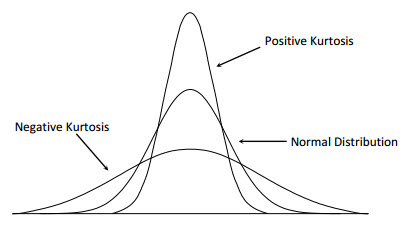


## Independent component analysis (ICA)

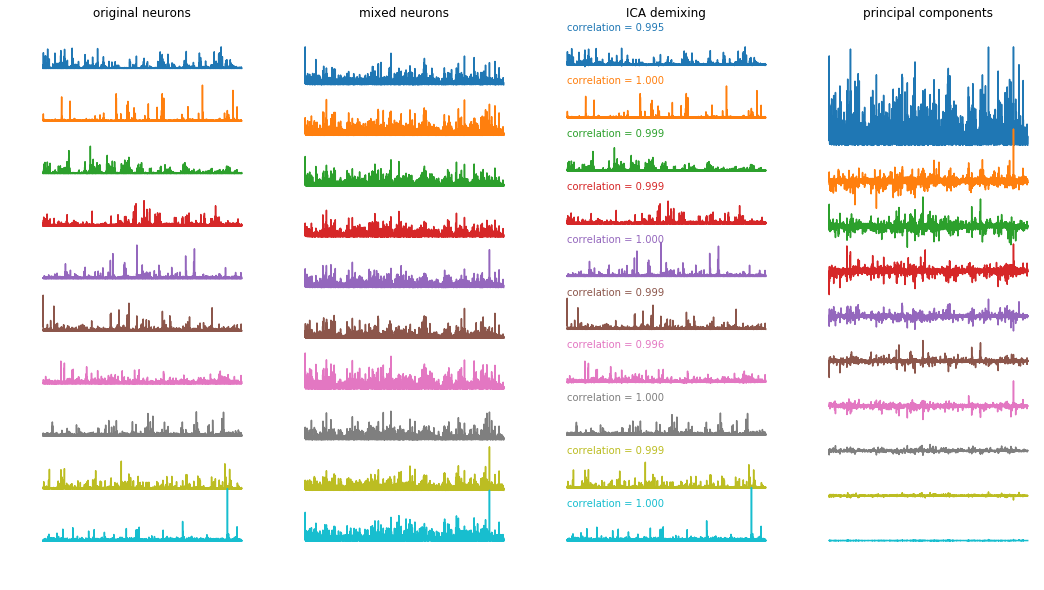

In [66]:
neurons = isort1[np.random.randint(6000, size=(10,))]
ica_example(sp, neurons)

## Independent component analysis (ICA)

The “independent components” of natural scenes are edge filters (Bell & Sejnowski, 1997)

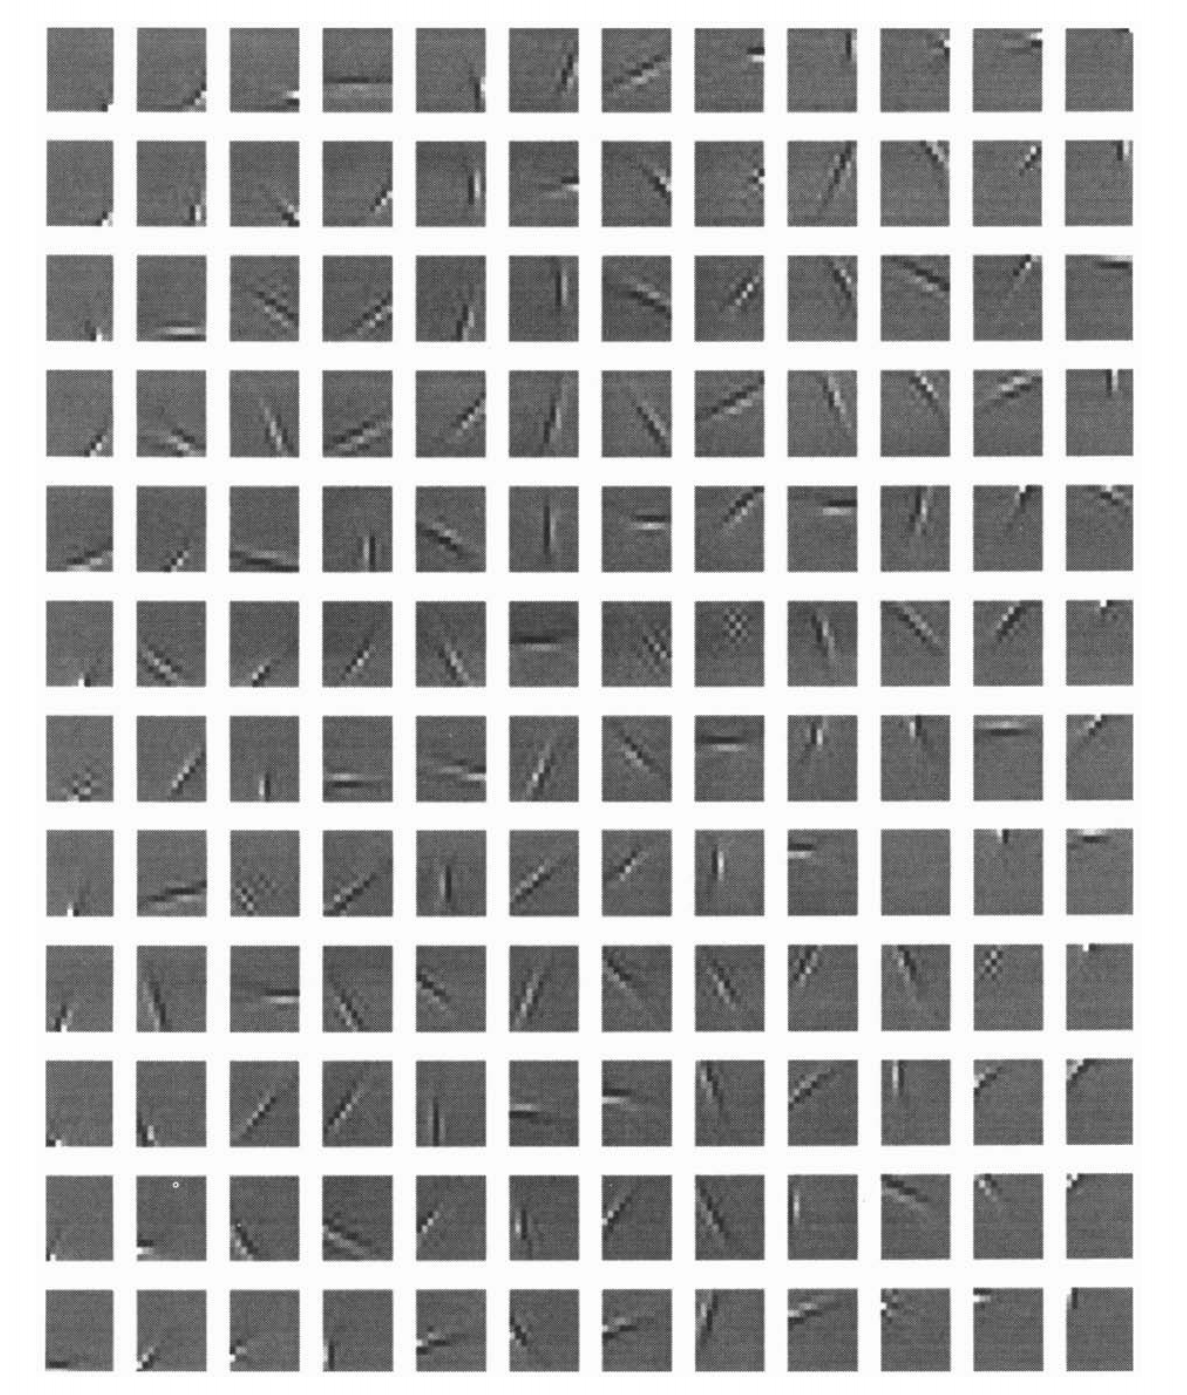


## Independent component analysis (ICA)

FastICA is implemented in scikit-learn (Hyvarinen & Oja, 2000). Steps:

* whiten data: set covariance matrix to identity
    * we now know how to whiten, use SVD!
    \begin{align*}
    \text{from SVD, } X &= U\Sigma V^\top \\
    X_{white} &= UV^\top \\
    \Rightarrow X_{white} X_{white}^\top &= (UV^\top)(UV^\top)^\top = UV^\top V U^\top = UU^\top = I
    \end{align*}

* find <b>w</b> that maximizes non-Gaussianity of projection <b>w<sup>T</sup>X</b>

* find next <b>w</b> that maximizes non-Gaussianity of projection <b>w<sup>T</sup>X</b>
    * on each step, force <b>w</b> to be orthogonal to previously found weights

## Independent component analysis (ICA)

### Pros
* finds sparse components

### Cons
* orthogonal dimensions
* still a linear model

t-SNE and UMAP can find non-linear components... let's check them out!

## t-SNE (student's t-distribution stochastic neighbor embedding)

(van der Maaten & Hinton, 2008)
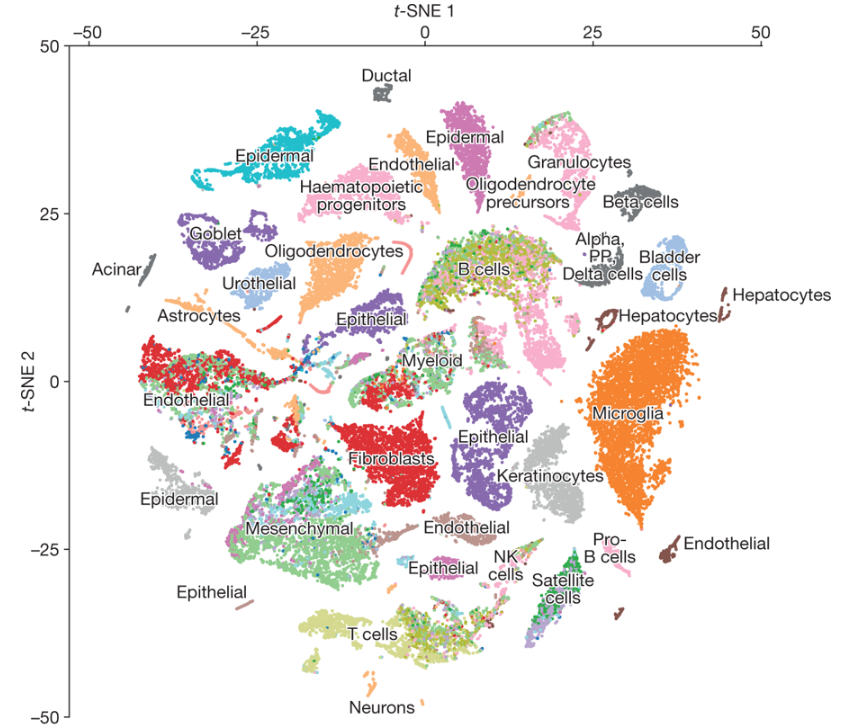


## t-SNE (student's t-distribution stochastic neighbor embedding)

(van der Maaten & Hinton, 2008) Tries to _embed neighbors_ in X near each other in a low-dimensional space Y

The probability that $x_i$ has neighbor $x_j$ is defined as

$p_{j|i} = \left. e^\frac{-\|x_i - x_j\|^2}{2 \sigma^2} \middle/ \sum\limits_{k,l} e^\frac{-\|x_k - x_l\|^2}{2 \sigma^2} \right.$

How much $\sigma$ varies across X is set by the **perplexity** 

<table><tr>
<td> <img src="https://umap-learn.readthedocs.io/en/latest/_images/how_umap_works_open_cover.png" alt="low_perplexity" style="width: 750px;"/> </td>
<td> <img src="https://umap-learn.readthedocs.io/en/latest/_images/how_umap_works_local_metric_open_cover.png" alt="high_perplexity" style="width: 750px;"/> </td>
</tr></table>
(images from UMAP)

## t-SNE (student's t-distribution stochastic neighbor embedding)


https://distill.pub/2016/misread-tsne/

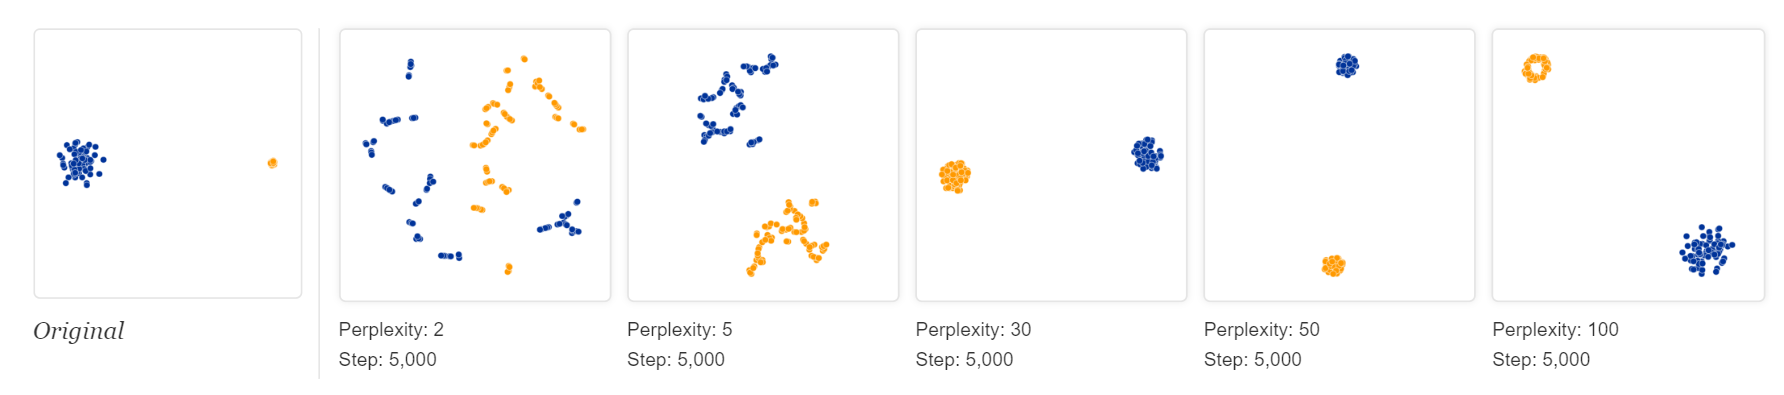



## t-SNE (student's t-distribution stochastic neighbor embedding)

(van der Maaten & Hinton, 2008) Tries to _embed neighbors_ in X near each other in a low-dimensional space Y

Probability of being neighbors in X should equal probability of being neighbors in Y
* optimize Y based on this constraint, not an easy optimization
* using the student's t-distribution ensures that neighbors in Y cannot be dissimilar in X
(READ IT AGAIN)
* "early exaggeration" - force tight-knit clusters to separate from each other and move around
    * this is a parameter you can vary (if it's too big it may not converge well)
 

## t-SNE (student's t-distribution stochastic neighbor embedding)

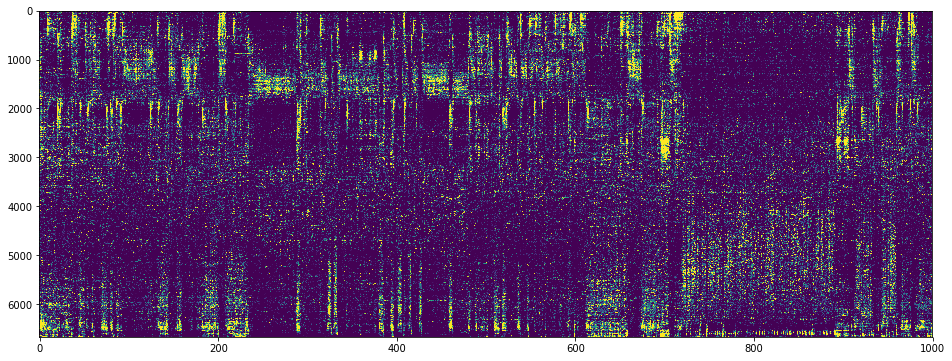

In [389]:
from MulticoreTSNE import MulticoreTSNE as TSNE # fast, multicore implementation by Dimitry Ulyanov

tsne = TSNE(n_components=1, n_jobs=8, perplexity=50, learning_rate=500, n_iter=2000)
out = tsne.fit_transform(sp)
iout = np.argsort(out[:,0])
fig = plt.figure(figsize=(16,6))
plt.imshow(gaussian_filter1d(sp[iout,:1000],5,axis=0),aspect='auto',vmin=.2,vmax=0.7)
plt.show()

## t-SNE (student's t-distribution stochastic neighbor embedding)

spatially localized clusters found...

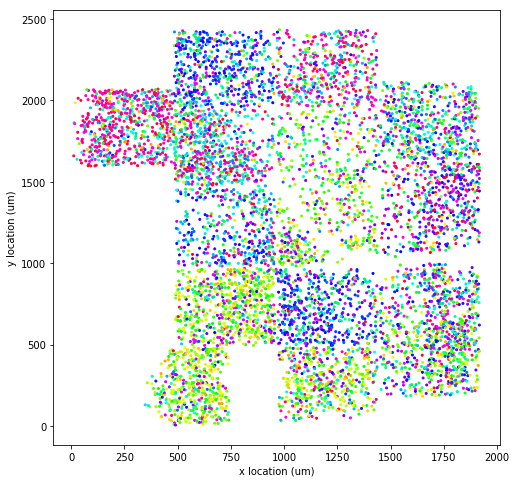

In [398]:
# make a colormap
cmap=matplotlib.cm.get_cmap('hsv'); cmap = cmap(np.linspace(0.1,1,sp.shape[0]))
plt.figure(figsize=(8,8))
# assign color based on t-SNE
plt.scatter(xyloc[:,0],xyloc[:,1],s=4,color=cmap[iout,:])
plt.xlabel('x location (um)'); plt.ylabel('y location (um)');
plt.show()

## t-SNE (student's t-distribution stochastic neighbor embedding)

Problems with t-SNE

https://distill.pub/2016/misread-tsne/

Cluster distances may not mean anything:
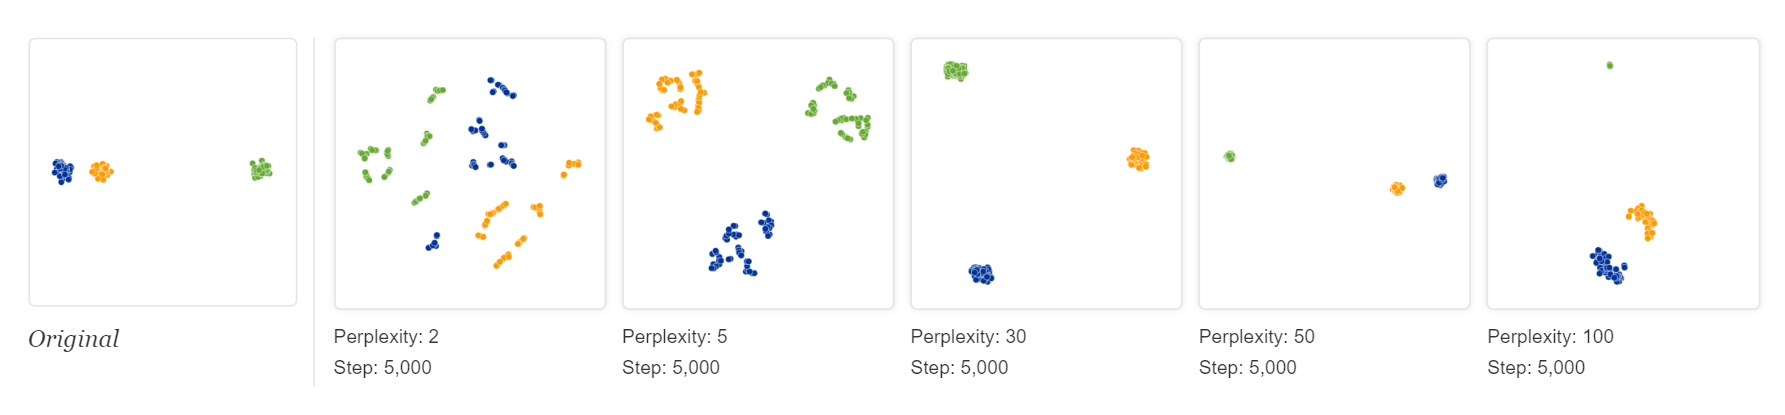


### UMAP (Uniform manifold approximation and projection) (McInnes & Healy, 2018)
* edges in graph formed between n-nearest neighbors (**n-neighbors** is a parameter)
* weights proportional to normalized distances

<table><tr>
<td> <img src="https://umap-learn.readthedocs.io/en/latest/_images/how_umap_works_raw_graph.png" alt="open_cover" style="width: 500px;"/> </td>
<td> <img src="https://umap-learn.readthedocs.io/en/latest/_images/how_umap_works_umap_open_cover.png" alt="raw_graph" style="width: 500px;"/> </td>

</tr></table>

Minimize cross-entropy across weights of edges (x original space, y low-D space):

$\sum_{e\in E} w_x(e) \log\left(\frac{w_x(e)}{w_y(e)}\right) + (1 - w_x(e)) \log\left(\frac{1 - w_x(e)}{1 - w_y(e)}\right)$

* first term is smallest if $w_y$ is large when $w_x$ is large (limit set by parameter **min_dist**)
* second term is smallest if $w_y$ is small when $w_x$ is small

## UMAP (Uniform manifold approximation and projection)

UMAP vs tSNE on single-cell RNAseq (Becht et al, 2018)
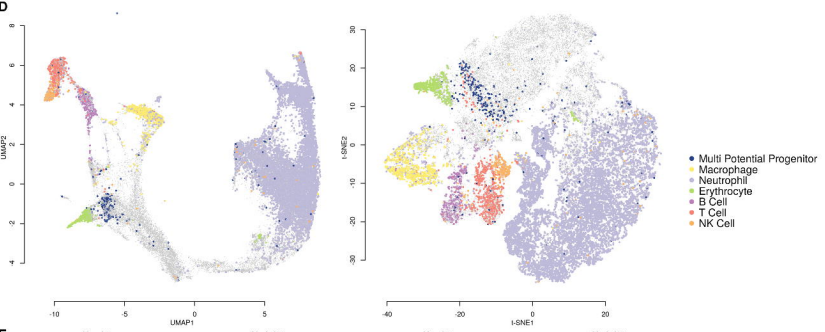

Clusters are more spread out, with bridges among them... do they mean anything?

Authors suggest that it tells them about genes associated with differentiation...